# Obesity Risk Prediction Model

This notebook builds and trains a Random Forest model to predict obesity risk based on various lifestyle and health factors.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Load and Prepare Data

In [2]:
# Load the dataset
data = pd.read_csv('../data/ObesityDataSet.csv')

# Split features and target
X = data.drop('NObeyesdad', axis=1)
y = data['NObeyesdad']

# Split numeric and categorical features
numeric_features = X.select_dtypes(exclude=['object']).columns
string_features = X.select_dtypes(include=['object']).columns

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode target variable
label = LabelEncoder()
y_train = label.fit_transform(y_train)
y_test = label.transform(y_test)

## Create Data Preprocessing Pipeline

In [3]:
# Create preprocessing pipelines for numeric and categorical features
string_transformer = Pipeline([
    ('One_Hot_Encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

numeric_transformer = Pipeline([
    ('Power_Transformer', PowerTransformer())
])

# Combine transformers
preprocessor = ColumnTransformer([
    ('numeric_transformer', numeric_transformer, numeric_features),
    ('string_transformer', string_transformer, string_features)
], remainder='passthrough')

## Create and Train Best Model

Using the best hyperparameters found through Optuna optimization:

In [4]:
# Initialize the best model with optimal hyperparameters
best_model = RandomForestClassifier(
    n_estimators=102,
    criterion='log_loss',
    max_depth=11,
    max_features=None,
    min_samples_split=6,
    min_samples_leaf=3,
    max_samples=0.9092488038970724,
    random_state=42
)

# Create pipeline with preprocessor and model
best_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model)
])

# Fit the pipeline
best_pipe.fit(X_train, y_train)

# Make predictions
y_preds = best_pipe.predict(X_test)

## Model Evaluation

In [5]:
# Calculate metrics
print(f"Accuracy: {accuracy_score(y_test, y_preds):.4f}")
print(f"Precision: {precision_score(y_test, y_preds, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_preds, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_preds, average='weighted'):.4f}")

Accuracy: 0.9574
Precision: 0.9583
Recall: 0.9574
F1 Score: 0.9576


## Feature Importance Analysis

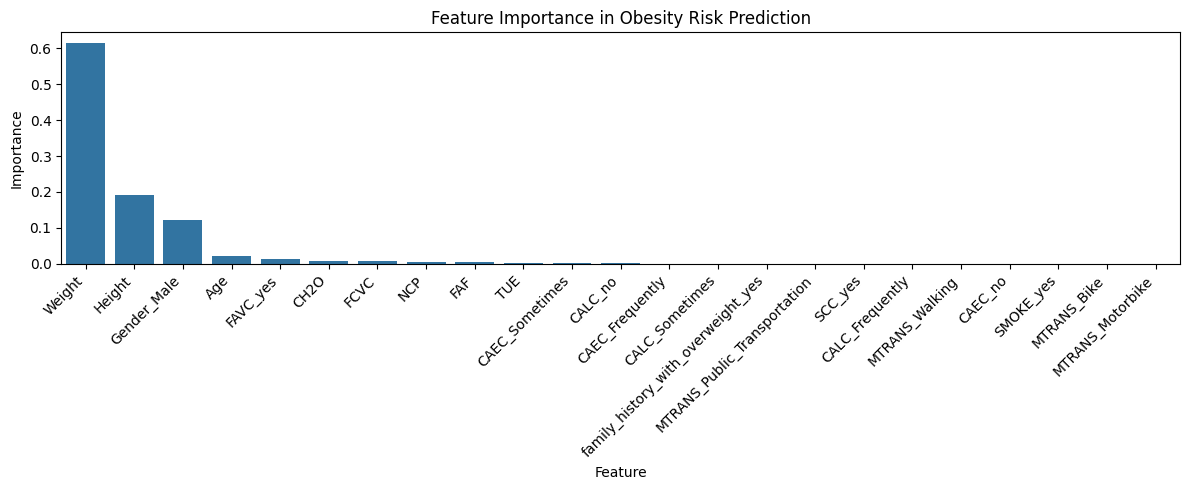

In [6]:
# Get feature names after preprocessing
preprocessor_feature_names = best_pipe.named_steps['preprocessor'].get_feature_names_out()
feature_names = np.array([s.split('__')[1] for s in preprocessor_feature_names])

# Get feature importances
importances = best_pipe.named_steps['model'].feature_importances_

# Create DataFrame of feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 5))
sns.barplot(data=feature_importances_df, x='Feature', y='Importance')
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance in Obesity Risk Prediction')
plt.tight_layout()
plt.show()

## Save the Model

In [7]:
# Save the entire pipeline (including preprocessor and model)
joblib.dump(best_pipe, '../Model/obesity_prediction_model.joblib')

# Save the label encoder for target variable
joblib.dump(label, '../Model/target_encoder.joblib')

print("Model and encoder saved successfully!")

Model and encoder saved successfully!
